# Taxi Fare
https://medium.com/swlh/lyft-surge-pricing-prediction-aa96114d9e1c

## 데이터 확인 및 가공

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cab_org = pd.read_csv('/Users/limkahyun/Desktop/small/Taxi/cab_rides.csv')
cab_df = cab_org.copy()
cab_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [2]:
cab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [3]:
weather_org = pd.read_csv('/Users/limkahyun/Desktop/small/Taxi/weather.csv')
weather_df = weather_org.copy()
weather_df.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


In [5]:
# rain 비가 안온날이 null이라 0으로 대체
weather_df = weather_df.fillna(0)

### Join or Merge 위한 컬럼 가공
시도1. time_stamp에서 동일한 앞에서 8글자까지만 자른다 >> 실패  
    date_time으로 변환했을 때 시간대가 아예 달라져버림
    
시도2. 시간단위 변환시 1초 이하 소수점이 나와서 실패  
cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp'], unit='ms')  
weather_df['date_time'] = pd.to_datetime(weather_df['time_stamp'], unit='s')

시도3. 검색해보니깐 Unix time의 밀리세컨드를 이용하고 있어서  
동일하게 1000으로 나눈 후 to_datetime으로 변환  
원래 location과 time_stamp 두개를 기준으로 join or merge 하려고 했는데  
새로운 컬럼에 시간-장소를 합쳐서 그것을 통해 조인시도 >> join()은 에러, merge()로 성공

In [6]:
cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000, unit='s')
weather_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000, unit='s')

In [7]:
# 장소와 시간을 합친 컬럼 생성 (시간은 hour까지만 사용)
cab_df['merge_date'] = cab_df['source'].astype(str) + ' - ' + cab_df['date_time'].dt.date.astype(str) + ' - ' + cab_df['date_time'].dt.hour.astype(str)
weather_df['merge_date'] = weather_df['location'].astype(str) + ' - ' + weather_df['date_time'].dt.date.astype(str) + ' - ' + weather_df['date_time'].dt.hour.astype(str)

# merge_date 기준으로 merge
merged_df = cab_df.merge(weather_df, on=['merge_date'], how='left')

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410210 entries, 0 to 1410209
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   distance          1410210 non-null  float64       
 1   cab_type          1410210 non-null  object        
 2   time_stamp_x      1410210 non-null  int64         
 3   destination       1410210 non-null  object        
 4   source            1410210 non-null  object        
 5   price             1297952 non-null  float64       
 6   surge_multiplier  1410210 non-null  float64       
 7   id                1410210 non-null  object        
 8   product_id        1410210 non-null  object        
 9   name              1410210 non-null  object        
 10  date_time_x       1410210 non-null  datetime64[ns]
 11  merge_date        1410210 non-null  object        
 12  temp              1268809 non-null  float64       
 13  location          1268809 non-null  object

In [10]:
merged_df.tail()[:10]

,distance,cab_type,time_stamp_x,destination,source,price,surge_multiplier,id,product_id,name,...,merge_date,temp,location,clouds,pressure,rain,time_stamp_y,humidity,wind,date_time_y
1410205,1.0,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,West End - 2018-12-01 - 23,20.06,West End,0.62,1030.21,0.0,1.544691e+09,0.61,3.76,2018-12-01 23:18:03.204
1410206,1.0,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,...,West End - 2018-12-01 - 23,20.06,West End,0.62,1030.21,0.0,1.544691e+09,0.61,3.76,2018-12-01 23:18:03.204
1410207,1.0,Uber,1543708385534,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,West End - 2018-12-01 - 23,20.06,West End,0.62,1030.21,0.0,1.544691e+09,0.61,3.76,2018-12-01 23:18:03.204
1410208,1.0,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,West End - 2018-12-01 - 23,20.06,West End,0.62,1030.21,0.0,1.544691e+09,0.61,3.76,2018-12-01 23:18:03.204
1410209,1.0,Uber,1543708385534,North End,West End,10.0,1.0,e7fdc087-fe86-40a5-a3c3-3b2a8badcbda,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,...,West End - 2018-12-01 - 23,20.06,West End,0.62,1030.21,0.0,1.544691e+09,0.61,3.76,2018-12-01 23:18:03.204


In [9]:
merged_df.isnull().sum(axis=0)

distance                 0
cab_type                 0
time_stamp_x             0
destination              0
source                   0
price               112258
surge_multiplier         0
id                       0
product_id               0
name                     0
date_time_x              0
merge_date               0
temp                141401
location            141401
clouds              141401
pressure            141401
rain                141401
time_stamp_y        141401
humidity            141401
wind                141401
date_time_y         141401
dtype: int64

### Null 제거 및 인코딩

In [10]:
# null값 제거
merged_df_drop = merged_df.dropna(axis=0)
merged_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167702 entries, 0 to 1410209
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   distance          1167702 non-null  float64       
 1   cab_type          1167702 non-null  object        
 2   time_stamp_x      1167702 non-null  int64         
 3   destination       1167702 non-null  object        
 4   source            1167702 non-null  object        
 5   price             1167702 non-null  float64       
 6   surge_multiplier  1167702 non-null  float64       
 7   id                1167702 non-null  object        
 8   product_id        1167702 non-null  object        
 9   name              1167702 non-null  object        
 10  date_time_x       1167702 non-null  datetime64[ns]
 11  merge_date        1167702 non-null  object        
 12  temp              1167702 non-null  float64       
 13  location          1167702 non-null  object

In [11]:
# merge_date를 인덱스로 주고 컬럼제거
merged_df_drop.index = merged_df_drop['merge_date']

# 필요없는 컬럼 제거
merged_df_drop = merged_df_drop.drop(columns=['time_stamp_x', 'destination', 'source', 'id', 'product_id', 'date_time_x',
                                    'time_stamp_y', 'date_time_y', 'location', 'merge_date', 'pressure'])
merged_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167702 entries, Haymarket Square - 2018-12-16 - 9 to West End - 2018-12-01 - 23
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   distance          1167702 non-null  float64
 1   cab_type          1167702 non-null  object 
 2   price             1167702 non-null  float64
 3   surge_multiplier  1167702 non-null  float64
 4   name              1167702 non-null  object 
 5   temp              1167702 non-null  float64
 6   clouds            1167702 non-null  float64
 7   rain              1167702 non-null  float64
 8   humidity          1167702 non-null  float64
 9   wind              1167702 non-null  float64
dtypes: float64(8), object(2)
memory usage: 98.0+ MB


In [12]:
merged_df_drop.head()

,distance,cab_type,price,surge_multiplier,name,temp,clouds,rain,humidity,wind
merge_date,,,,,,,,,,
Haymarket Square - 2018-12-16 - 9,0.44,Lyft,5.0,1.0,Shared,38.52,0.75,0.0,0.69,11.11
Haymarket Square - 2018-12-16 - 9,0.44,Lyft,5.0,1.0,Shared,33.10,0.35,0.0,0.82,6.57
Haymarket Square - 2018-11-27 - 2,0.44,Lyft,11.0,1.0,Lux,20.26,0.45,0.0,0.63,2.90
Haymarket Square - 2018-11-27 - 2,0.44,Lyft,11.0,1.0,Lux,36.08,0.73,0.0,0.72,7.76
Haymarket Square - 2018-11-27 - 2,0.44,Lyft,11.0,1.0,Lux,41.05,0.16,0.0,0.59,9.10


In [13]:
# object컬럼을 숫자형으로 변환 : 원-핫 인코딩 이용
merged_df_oh = pd.get_dummies(merged_df_drop)
print('원핫인코딩 수행 전 shape : ', merged_df_drop.shape)
print('원핫인코딩 수행 후 shape : ', merged_df_oh.shape)

원핫인코딩 수행 전 shape :  (1167702, 10)
원핫인코딩 수행 후 shape :  (1167702, 22)


### 상관관계 확인

In [14]:
merged_df_oh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167702 entries, Haymarket Square - 2018-12-16 - 9 to West End - 2018-12-01 - 23
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   distance           1167702 non-null  float64
 1   price              1167702 non-null  float64
 2   surge_multiplier   1167702 non-null  float64
 3   temp               1167702 non-null  float64
 4   clouds             1167702 non-null  float64
 5   rain               1167702 non-null  float64
 6   humidity           1167702 non-null  float64
 7   wind               1167702 non-null  float64
 8   cab_type_Lyft      1167702 non-null  uint8  
 9   cab_type_Uber      1167702 non-null  uint8  
 10  name_Black         1167702 non-null  uint8  
 11  name_Black SUV     1167702 non-null  uint8  
 12  name_Lux           1167702 non-null  uint8  
 13  name_Lux Black     1167702 non-null  uint8  
 14  name_Lux Black XL  1167702 non-null 

<AxesSubplot:xlabel='name', ylabel='price'>

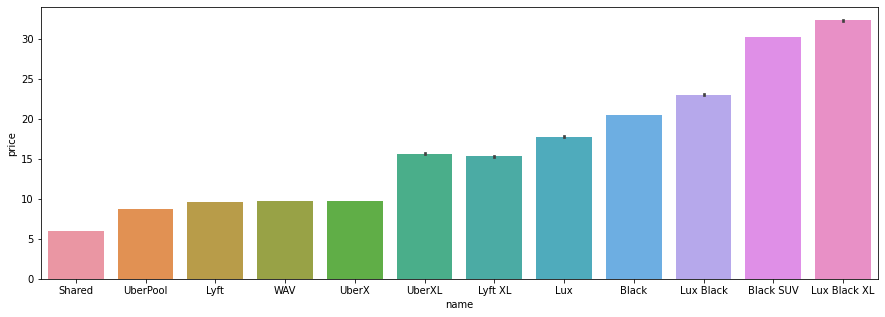

In [15]:
# 가격 순으로 정렬
merged_df_drop = merged_df_drop.sort_values(by=['price'])
merged_df_oh = merged_df_oh.sort_values(by=['price'])

# merged_df_drop에서 차량등급에 따른 가격 (인코딩 전 DF) >> 등급에 따라 가격이 다름을 알 수 있음
plt.figure(figsize=(15, 5))
sns.barplot(x='name', y='price', data=merged_df_drop)

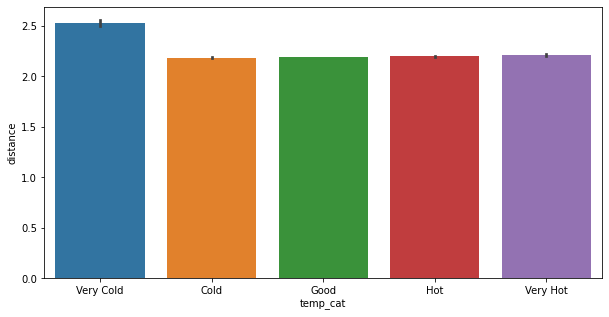

In [16]:
# 거리 순으로 정렬
merged_df_drop = merged_df_drop.sort_values(by=['distance'])
merged_df_oh = merged_df_oh.sort_values(by=['distance'])

# 온도카테고리
def get_category(temp):
    cat=''
    if temp <= 20: cat = 'Very Cold'
    elif temp <= 30: cat = 'Cold'
    elif temp <= 40: cat = 'Good'
    elif temp <= 50: cat = 'Hot'
    else : cat = 'Very Hot'
    
    return cat

# x축을 내가 원하는 순서로 정리
x_names = ['Very Cold', 'Cold', 'Good', 'Hot', 'Very Hot']

# lambda 이용
merged_df_drop['temp_cat'] = merged_df_drop['temp'].apply(lambda x : get_category(x))

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x='temp_cat', y='distance', data=merged_df_drop, order=x_names)
merged_df_drop.drop('temp_cat', axis=1, inplace=True)

# 온도에 따른 거리변화는 큰 의미 없음

<AxesSubplot:>

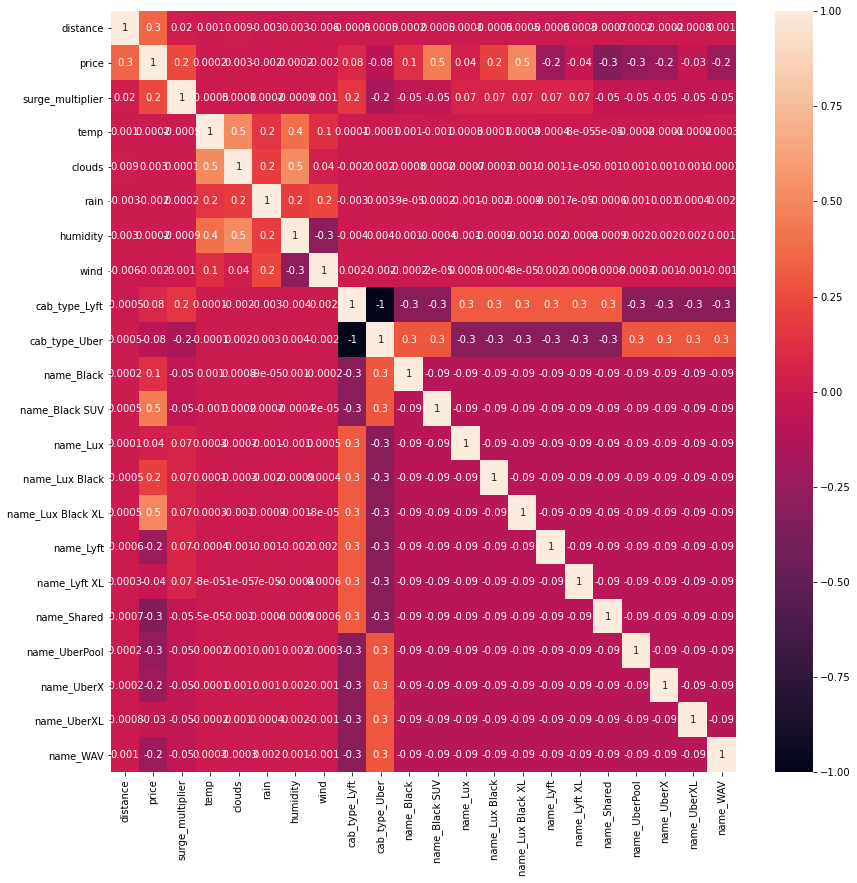

In [17]:
# corr()를 이용해 속성간 상관도 구한 뒤 히트맵으로 시각화
corr = merged_df_oh.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr, annot=True, fmt='.1g')

In [18]:
corr.price.sort_values(ascending=False)

price                1.000000
name_Lux Black XL    0.501197
name_Black SUV       0.451761
distance             0.346047
surge_multiplier     0.240394
name_Lux Black       0.205868
name_Black           0.130731
cab_type_Lyft        0.084418
name_Lux             0.039479
clouds               0.002675
temp                 0.000177
humidity             0.000173
wind                -0.001713
rain                -0.001986
name_UberXL         -0.029140
name_Lyft XL        -0.038726
cab_type_Uber       -0.084418
name_Lyft           -0.220080
name_UberX          -0.223079
name_WAV            -0.223338
name_UberPool       -0.256864
name_Shared         -0.332821
Name: price, dtype: float64

### 함수 생성

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    return rmse
    
def get_mae(model):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test,pred)
    return mae

def get_mape(model):
    pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, pred)
    return mape

def get_r2(model):
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    return r2

def check_errors(models):
    rmses = []
    maes = []
    mapes = []
    r2s = []
    
    for model in models:
        rmse = get_rmse(model)
        mae = get_mae(model)
        mape = get_mape(model)
        r2 = get_r2(model)
        
        rmses.append(rmse)
        maes.append(mae)
        mapes.append(mape)
        r2s.append(r2)
        
        print(model.__class__.__name__, 'RMSE :', np.round(rmse, 3), '/ MAE :', np.round(mae, 3), '/ MAPE :', np.round(mape, 3), '/ R2 :', np.round(r2, 3))
    return rmses, maes, mapes, r2

### 모델 학습, 예측, 평가

In [20]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

# 데이터 분리
y_target = merged_df_oh['price']
X_features = merged_df_oh.drop(['price'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

# 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

rg_reg = Ridge()
rg_reg.fit(X_train, y_train)

ls_reg = Lasso()
ls_reg.fit(X_train, y_train)

models = [lr_reg, rg_reg, ls_reg]
check_errors(models)

LinearRegression RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928
Ridge RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928
Lasso RMSE : 7.922 / MAE : 6.548 / MAPE : 0.545 / R2 : 0.28


([2.5128257736350292, 2.5128250565225896, 7.921549312031209],
 [1.777827158943693, 1.7778154697259896, 6.548447979199651],
 [0.1343145967963501, 0.13431305464485985, 0.5445170713385202],
 0.2804989687160965)

<AxesSubplot:>

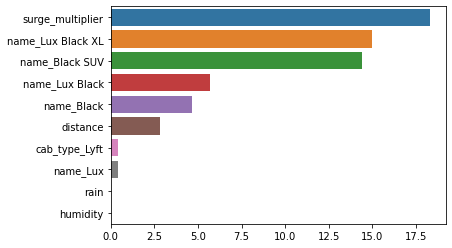

In [21]:
# 회귀계수 높은 순서대로 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 정확도를 높이기 위한 여러가지 시도
**1. 타겟의 로그변환**

<AxesSubplot:>

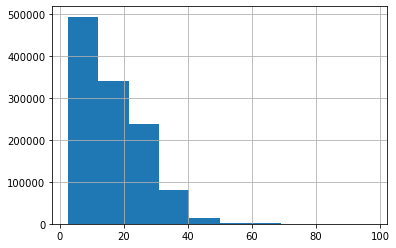

In [22]:
# 타겟의 분포도 확인
y_target.hist()

<AxesSubplot:>

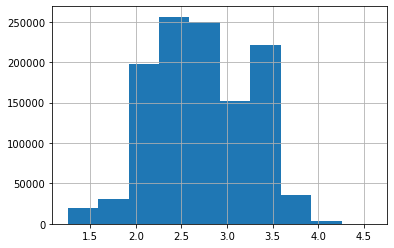

In [23]:
y_log_target = np.log1p(y_target)
y_log_target.hist()

In [24]:
# 타겟값을 로그변환한 것을 사용했기 때문에 테스트 데이터 세트의 타겟값과 예측값을 로그변환 이전으로 돌려주는 식 추가
def get_rmse_log(model):
    pred = model.predict(X_test)
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)
    
    mse = mean_squared_error(y_test_exp, pred_exp)
    rmse = np.sqrt(mse)
    return rmse
    
def get_mae_log(model):
    pred = model.predict(X_test)
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)
    
    mae = mean_absolute_error(y_test_exp, pred_exp)
    return mae

def get_mape_log(model):
    pred = model.predict(X_test)
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)
    
    mape = mean_absolute_percentage_error(y_test_exp, pred_exp)
    return mape

def get_r2_log(model):
    pred = model.predict(X_test)
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)
    
    r2 = r2_score(y_test_exp, pred_exp)
    return r2

def check_errors_log(models):
    rmses = []
    maes = []
    mapes = []
    r2s = []
    
    for model in models:
        rmse = get_rmse_log(model)
        mae = get_mae_log(model)
        mape = get_mape_log(model)
        r2 = get_r2_log(model)
        
        rmses.append(rmse)
        maes.append(mae)
        mapes.append(mape)
        r2s.append(r2)
        
        print(model.__class__.__name__, '\n RMSE :', np.round(rmse, 3), '/ MAE :', np.round(mae, 3), '/ MAPE :', np.round(mape, 3), '/ R2 :', np.round(r2, 3))
    return rmses, maes, mapes, r2

In [25]:
# 피쳐값도 로그변환
X_log_features = np.log1p(X_features)

# 데이터 분리
y_target = merged_df_oh['price']
X_features = merged_df_oh.drop(['price'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_log_target, test_size=0.2, random_state=0)

# 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

rg_reg = Ridge()
rg_reg.fit(X_train, y_train)

ls_reg = Lasso()
ls_reg.fit(X_train, y_train)

models = [lr_reg, rg_reg, ls_reg]
check_errors_log(models)

LinearRegression 
 RMSE : 2.139 / MAE : 1.436 / MAPE : 0.1 / R2 : 0.948
Ridge 
 RMSE : 2.139 / MAE : 1.436 / MAPE : 0.1 / R2 : 0.948
Lasso 
 RMSE : 9.601 / MAE : 7.398 / MAPE : 0.537 / R2 : -0.057


([2.1394051660726503, 2.1394050099642503, 9.600966334183877],
 [1.436308396725177, 1.4363085292804838, 7.398186619669313],
 [0.09959134514265115, 0.0995914630659364, 0.536644638374297],
 -0.05691741603805678)

<AxesSubplot:>

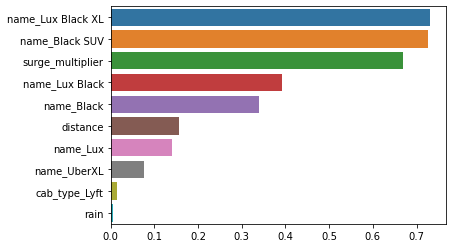

In [26]:
# 회귀계수 높은 순서대로 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

---
원본데이터 평가  
LinearRegression RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928  
Ridge RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928  
Lasso RMSE : 7.922 / MAE : 6.548 / MAPE : 0.545 / R2 : 0.28  

선형회귀, 릿지는 예측 성능이 조금 좋아졌지만 라쏘는 예측성능이 좋아졌다고 보기 어렵다  
회귀계수로 봤을 때 surge_multiplier가 가장 높은 회귀계수를 가지고 있었는데 Lux Black XL이 가장 높은 회귀계수값을 보였다

---

**2. x값 스케일링**

In [27]:
from sklearn.preprocessing import StandardScaler

# 데이터세트에서 y값 제거
merged_df_x = merged_df_oh.drop(['price'],axis=1,inplace=False)

# StandardScaler 객체 생성
st_scaler = StandardScaler()

# StandardScaler로 데이터 세트 변환
st_scaler.fit(merged_df_x)
merged_st = st_scaler.transform(merged_df_x)

# 데이터프레임으로 변환
merged_df_st = pd.DataFrame(data=merged_st, columns=merged_df_x.columns)
merged_df_st.describe()

,distance,surge_multiplier,temp,clouds,rain,humidity,wind,cab_type_Lyft,cab_type_Uber,name_Black,...,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV
count,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,...,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06,1.167702e+06
mean,-2.019000e-13,-2.845983e-13,1.500753e-15,1.028414e-14,-8.431339e-17,5.397904e-15,2.873471e-15,-2.800175e-14,2.800175e-14,2.329433e-14,...,-1.280946e-14,-1.029121e-14,-9.064060e-14,6.062623e-14,-1.589892e-14,-1.622924e-14,1.823221e-14,-6.795082e-14,7.358344e-14,-4.671396e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.911663e+00,-1.581417e-01,-3.242556e+00,-2.154152e+00,-1.931616e-01,-2.466479e+00,-1.792625e+00,-9.650847e-01,-1.036179e+00,-3.073763e-01,...,-2.961872e-01,-2.950312e-01,-2.958142e-01,-2.960538e-01,-2.956241e-01,-2.950706e-01,-3.073246e-01,-3.066883e-01,-3.083082e-01,-3.073629e-01
25%,-8.040967e-01,-1.581417e-01,-4.872779e-01,-7.558894e-01,-1.931616e-01,-7.403601e-01,-9.028124e-01,-9.650847e-01,-1.036179e+00,-3.073763e-01,...,-2.961872e-01,-2.950312e-01,-2.958142e-01,-2.960538e-01,-2.956241e-01,-2.950706e-01,-3.073246e-01,-3.066883e-01,-3.083082e-01,-3.073629e-01
50%,-2.176783e-02,-1.581417e-01,1.673922e-01,3.245863e-01,-1.931616e-01,-3.422069e-02,-6.792686e-02,-9.650847e-01,9.650847e-01,-3.073763e-01,...,-2.961872e-01,-2.950312e-01,-2.958142e-01,-2.960538e-01,-2.956241e-01,-2.950706e-01,-3.073246e-01,-3.066883e-01,-3.083082e-01,-3.073629e-01
75%,6.550785e-01,-1.581417e-01,6.238290e-01,9.283815e-01,-1.931616e-01,9.857585e-01,8.548414e-01,1.036179e+00,9.650847e-01,-3.073763e-01,...,-2.961872e-01,-2.950312e-01,-2.958142e-01,-2.960538e-01,-2.956241e-01,-2.950706e-01,-3.073246e-01,-3.066883e-01,-3.083082e-01,-3.073629e-01
max,4.979863e+00,2.061612e+01,2.719440e+00,1.023718e+00,1.802402e+01,1.770358e+00,3.120567e+00,1.036179e+00,9.650847e-01,3.253341e+00,...,3.376243e+00,3.389473e+00,3.380500e+00,3.377764e+00,3.382674e+00,3.389019e+00,3.253889e+00,3.260640e+00,3.243508e+00,3.253483e+00


In [28]:
# 데이터 분리
y_target = merged_df_oh['price']
X_features = merged_df_x

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

# 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

rg_reg = Ridge()
rg_reg.fit(X_train, y_train)

ls_reg = Lasso()
ls_reg.fit(X_train, y_train)

models = [lr_reg, rg_reg, ls_reg]
check_errors(models)

LinearRegression RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928
Ridge RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928
Lasso RMSE : 7.922 / MAE : 6.548 / MAPE : 0.545 / R2 : 0.28


([2.5128257736350292, 2.5128250565225896, 7.921549312031209],
 [1.777827158943693, 1.7778154697259896, 6.548447979199651],
 [0.1343145967963501, 0.13431305464485985, 0.5445170713385202],
 0.2804989687160965)

<AxesSubplot:>

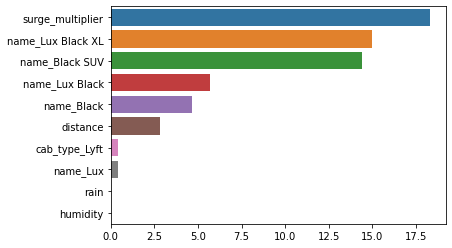

In [29]:
# 회귀계수 높은 순서대로 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [30]:
from sklearn.preprocessing import MinMaxScaler

# 데이터세트에서 y값 제거
merged_df_x = merged_df_oh.drop(['price'],axis=1,inplace=False)

# StandardScaler 객체 생성
mm_scaler = MinMaxScaler()

# StandardScaler로 데이터 세트 변환
mm_scaler.fit(merged_df_x)
merged_mm = mm_scaler.transform(merged_df_x)

# 데이터프레임으로 변환
merged_df_mm = pd.DataFrame(data=merged_mm, columns=merged_df_x.columns)

In [31]:
# 데이터 분리
y_target = merged_df_oh['price']
X_features = merged_df_x

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

# 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

rg_reg = Ridge()
rg_reg.fit(X_train, y_train)

ls_reg = Lasso()
ls_reg.fit(X_train, y_train)

models = [lr_reg, rg_reg, ls_reg]
check_errors(models)

LinearRegression RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928
Ridge RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928
Lasso RMSE : 7.922 / MAE : 6.548 / MAPE : 0.545 / R2 : 0.28


([2.5128257736350292, 2.5128250565225896, 7.921549312031209],
 [1.777827158943693, 1.7778154697259896, 6.548447979199651],
 [0.1343145967963501, 0.13431305464485985, 0.5445170713385202],
 0.2804989687160965)

<AxesSubplot:>

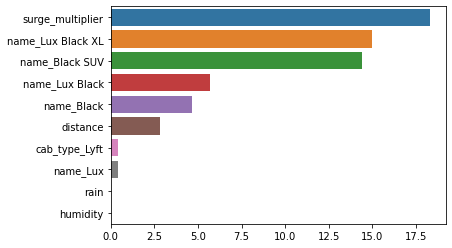

In [32]:
# 회귀계수 높은 순서대로 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

---
스케일링은 standard, minmax모두 큰 성능 변화 없었음

---
**3. 원본과 타겟의 로그변환 데이터를 이용해 다른 모델 적용**

In [33]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 분리
y_target = merged_df_oh['price']
X_features = merged_df_oh.drop(['price'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

# 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

rg_reg = Ridge()
rg_reg.fit(X_train, y_train)

ls_reg = Lasso()
ls_reg.fit(X_train, y_train)

rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

gbm_reg = GradientBoostingRegressor()
gbm_reg.fit(X_train, y_train)

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

models = [lr_reg, rg_reg, ls_reg, rf_reg, gbm_reg, xgb_reg]
check_errors(models)

LinearRegression RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928
Ridge RMSE : 2.513 / MAE : 1.778 / MAPE : 0.134 / R2 : 0.928
Lasso RMSE : 7.922 / MAE : 6.548 / MAPE : 0.545 / R2 : 0.28
RandomForestRegressor RMSE : 1.863 / MAE : 1.213 / MAPE : 0.09 / R2 : 0.96
GradientBoostingRegressor RMSE : 1.878 / MAE : 1.286 / MAPE : 0.096 / R2 : 0.96
XGBRegressor RMSE : 1.71 / MAE : 1.132 / MAPE : 0.083 / R2 : 0.966


([2.5128257736350292,
  2.5128250565225896,
  7.921549312031209,
  1.8628665651423215,
  1.8782731360025717,
  1.7098407421676476],
 [1.777827158943693,
  1.7778154697259896,
  6.548447979199651,
  1.212568389488748,
  1.2862096871520081,
  1.1323232886638517],
 [0.1343145967963501,
  0.13431305464485985,
  0.5445170713385202,
  0.08958521881330796,
  0.09638796865261372,
  0.08340210207372949],
 0.9664785741586468)

r2는 1에 가까울수록 좋은 값
예측 성능이 가장 좋은 것은 XGB모델

로그변환한 데이터 분리, 학습, 예측, 평가

In [34]:
# 데이터 분리
y_target = merged_df_oh['price']
y_log_target = np.log1p(y_target)
X_features = merged_df_oh.drop(['price'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_log_target, test_size=0.2, random_state=0)

# 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

rg_reg = Ridge()
rg_reg.fit(X_train, y_train)

ls_reg = Lasso()
ls_reg.fit(X_train, y_train)

rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

gbm_reg = GradientBoostingRegressor()
gbm_reg.fit(X_train, y_train)

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

models = [lr_reg, rg_reg, ls_reg, rf_reg, gbm_reg, xgb_reg]
check_errors_log(models)

LinearRegression 
 RMSE : 2.139 / MAE : 1.436 / MAPE : 0.1 / R2 : 0.948
Ridge 
 RMSE : 2.139 / MAE : 1.436 / MAPE : 0.1 / R2 : 0.948
Lasso 
 RMSE : 9.601 / MAE : 7.398 / MAPE : 0.537 / R2 : -0.057
RandomForestRegressor 
 RMSE : 1.845 / MAE : 1.199 / MAPE : 0.088 / R2 : 0.961
GradientBoostingRegressor 
 RMSE : 1.938 / MAE : 1.278 / MAPE : 0.091 / R2 : 0.957
XGBRegressor 
 RMSE : 1.721 / MAE : 1.127 / MAPE : 0.082 / R2 : 0.966


([2.1394051660726503,
  2.1394050099642503,
  9.600966334183877,
  1.8452216646322401,
  1.9381098976754865,
  1.7207457000316808],
 [1.436308396725177,
  1.4363085292804838,
  7.398186619669313,
  1.1992770264045944,
  1.2784441404460594,
  1.1269646856703672],
 [0.09959134514265115,
  0.0995914630659364,
  0.536644638374297,
  0.08794937784557207,
  0.0911717965690246,
  0.081895497825248],
 0.9660496272725816)

### 결과
unix 밀리초로 되어있는 시간데이터를 datetime으로 변경  
시간과 장소를 합친 새로운 컬럼 생성  
이렇게 만든 새로운 컬럼을 기준으로 merge  
null값 처리, 상관관계 높은 피쳐만 추출  
학습, 예측, 평가

**정확도 높이기**
1. 로그변환을 하면 선형회귀와 릿지는 성능이 약간 향상됨  
2. 스케일링은 별로 효과 없었음

원본데이터와 로그변환한 데이터에 대해 가장 높은 예측성능을 보인것은 XGBoost